In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sciopy import EIT_16_32_64_128, EitMeasurementSetup
import matplotlib.pyplot as plt

In [2]:
# create a 'sciospec' class which represents the sciospec EIT device
n_el = 32
sciospec = EIT_16_32_64_128(n_el)

In [3]:
# connect device via USB-HS port
sciospec.connect_device_HS()

In [4]:
# read system message buffer
sciospec.SystemMessageCallback()
# should be empty

No message inside the message buffer
message buffer:
 []
message length:	 0


In [5]:
# create a measurement setup
setup = EitMeasurementSetup(
    burst_count=5,
    n_el=n_el,
    exc_freq=125_000,
    framerate=3,
    amplitude=0.01,
    inj_skip=n_el // 2,
    gain=1,
    adc_range=1,
)

In [6]:
sciospec.SetMeasurementSetup(setup)

Command-Acknowledge: Command has been executed successfully
message buffer:
 ['0x18', '0x1', '0x83', '0x18']
message length:	 4
Command-Acknowledge: Command has been executed successfully
message buffer:
 ['0x18', '0x1', '0x83', '0x18']
message length:	 4
Command-Acknowledge: Command has been executed successfully
message buffer:
 ['0x18', '0x1', '0x83', '0x18']
message length:	 4
Command-Acknowledge: Command has been executed successfully
message buffer:
 ['0x18', '0x1', '0x83', '0x18']
message length:	 4


In [7]:
# get data
data = sciospec.StartStopMeasurement(return_as="pot_mat")  # or "hex"  # kommt in for schleife 

In [8]:
data.shape   #mitteln, 1-4 burst count für training, und 5. für test 

(5, 32, 32)

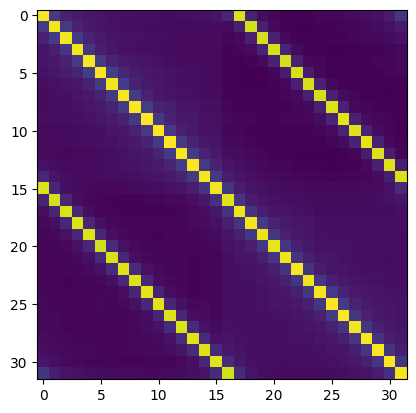

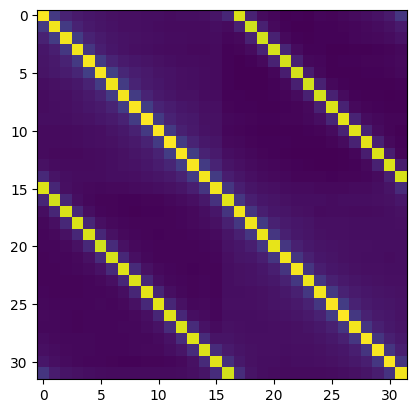

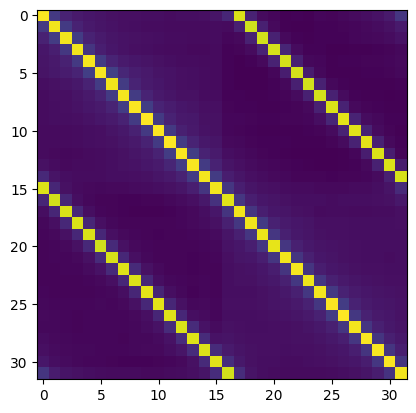

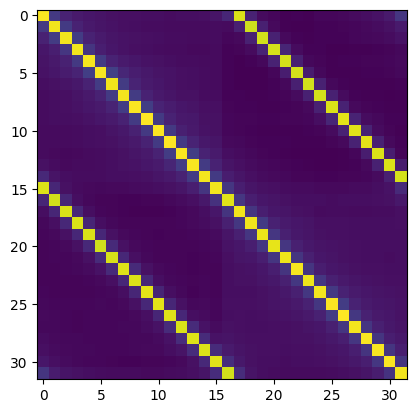

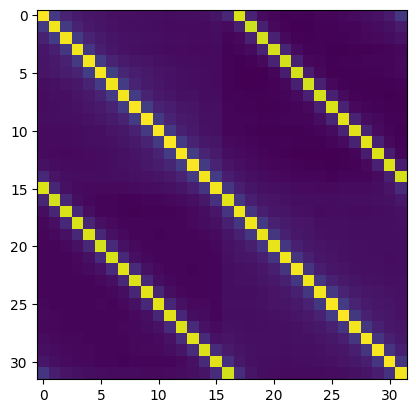

In [9]:
for pot in data:
    plt.imshow(np.abs(pot))
    plt.show()

## Ender 5

In [30]:
import serial

from typing import Union
import time
from datetime import datetime
import numpy as np
import sys
import glob
from src.util import (
    createTrajectory,
)
import os
from glob import glob
from tqdm import tqdm
# https://reprap.org/wiki/G-code#M17:_Enable.2FPower_all_stepper_motors


In [31]:
def command(ser, command) -> None:
    ser.write(str.encode(command))
    time.sleep(1)
    while True:
        line = ser.readline()
        print(line)

        if line == b"ok\n":
            break

# class
class EnderControl:
    def __init__(self,com_port, baudrate = 115200, timeout = 1, motion_speed = 1000):
        self.com_port = com_port
        self.baudrate = baudrate
        self.motion_speed = motion_speed # movement in mm/min
        self.position_timestamps = []  # Hier wird das Attribut position_timestamps korrekt initialisiert


    def connect(self):
        com = serial.Serial(
            port=self.com_port,
            baudrate=self.baudrate,
            parity=serial.PARITY_NONE,
            stopbits=serial.STOPBITS_ONE,
            bytesize=serial.EIGHTBITS,
        )
    
        print("Connection to", com.name, "is established.")
        self.com = com
        
    def init(self):
        """
        Initialise the axis
        """
        # x_y_home(ser)
        command(self.com, f"G28 X0 Y0 F{self.motion_speed}\r\n")
        command(self.com, f"G28 Z0 F{self.motion_speed}\r\n")
        self.x_y_center()
        self.turn_off_fan()
        print("X,Y axis are centered at X(180), Y(180)")

        return [180, 180]
    
    def turn_off_fan(self):
        command(self.com, "M106 S0\r\n")

    def x_y_center(self):
        command(self.com, f"G0 X180 Y180 F{self.motion_speed}\r\n")

    def move_to_absolute_x_y(self, P) -> None:
        command(
            self.com,
            f"G0 X{P[0]+180} Y{P[1]+180} F{self.motion_speed}\r\n",
        )
        pos = [P[0]+180, P[1]+180]
        return pos

    def read_temperature(self) -> float:
        """
        Read the bed temperature of the Ender 5.
    
        This function sends the M105 command, which requests the current temperature.
    
        Returns
        -------
        float
            The bed temperature value.
        """
    
        self.com.write(str.encode(f"M105\r\n"))
        time.sleep(1)
        line = self.com.readline()
        temp = float(str(line).split("B:")[1].split(" ")[0])
        
        return temp

    def get_timestamp(self) -> str:
        """
        Returns the current timestamp in the format YYYY-MM-DD HH:MM:SS
        """
        current_time = datetime.now()  # Get the current date and time
        formatted_timestamp = current_time.strftime("%Y-%m-%d %H:%M:%S")  # Format the timestamp
        return current_time, formatted_timestamp


In [32]:
printer = EnderControl(com_port="/dev/ttyUSB1")

In [33]:
printer.connect()

Connection to /dev/ttyUSB1 is established.


**[EIT measurement](https://github.com/EITLabworks/sciopy/blob/USB_fs_rework/examples/example_notebook.ipynb)**

In [34]:
def generate_exp_data(traj, r_path, r_anomaly, Nsteps, material, empty_tank_pos, empty_tank_timestamp, empty_tank_machine_time, empty_tank_temp, empty_tank_data):
    # Berechne die Trajektorie
    center_pos = createTrajectory("Kreis", r_path*97, r_path_variations=None, bound=0, num_points=Nsteps)
    
    # Erstelle den Basisordner für die Datenspeicherung
    base_dataset_folder = "exp_data_set"
    os.makedirs(base_dataset_folder, exist_ok=True)
    
    # Bestimme den Ordnernamen
    base_name = "exp_data"
    counter = 1
    folder_name = os.path.join(base_dataset_folder, base_name)
    while os.path.exists(folder_name):
        folder_name = os.path.join(base_dataset_folder, f"{base_name}{counter}")
        counter += 1
    os.makedirs(folder_name)
    
    # Logge die Parameter
    lookup = {
        "folder": folder_name,
        "Trajectory": traj,
        "Nsteps": Nsteps,
        "r_anomaly": r_anomaly,
        "r_path": r_path,
        "material": material,
    }

    lookup_file_path = os.path.join(base_dataset_folder, "exp_data_log.txt")
    with open(lookup_file_path, 'a') as f:
        for key, value in lookup.items():
            f.write(f"{key}: {value}\n")
        f.write("-" * 40 + "\n")

    # Speichere die leeren Tankmessungen als ersten Datensatz
    file_path = os.path.join(folder_name, "sample_000000.npz")
    np.savez(file_path, position=empty_tank_pos, timestamp=empty_tank_timestamp, 
             machine_time=empty_tank_machine_time, temperature=empty_tank_temp, v=empty_tank_data)
    
    for save_index, Ps in tqdm(enumerate(center_pos)):  
        pos = printer.move_to_absolute_x_y(Ps)  
        temp = printer.read_temperature()  
        machine_time, timestamp = printer.get_timestamp()  
        data = sciospec.StartStopMeasurement(return_as="pot_mat")  
        file_path = os.path.join(folder_name, f"sample_{save_index + 1:06d}.npz")
        np.savez(file_path, position=pos, timestamp=timestamp, machine_time=machine_time, 
                 temperature=temp, v=data)

    print("Measurement is complete!")


In [35]:
printer.init()

b'echo:busy: processing\n'
b'echo:busy: processing\n'
b'echo:busy: processing\n'
b'echo:busy: processing\n'
b'X:360.00 Y:360.00 Z:10.00 E:0.00 Count X:28800 Y:28800 Z:8000\n'
b'ok\n'
b'echo:busy: processing\n'
b'echo:busy: processing\n'
b'echo:busy: processing\n'
b'echo:busy: processing\n'
b'echo:busy: processing\n'
b'echo:busy: processing\n'
b'echo:busy: processing\n'
b'echo:busy: processing\n'
b'X:180.00 Y:180.00 Z:10.00 E:0.00 Count X:14400 Y:14400 Z:8000\n'
b'ok\n'
b'ok\n'
b'ok\n'
X,Y axis are centered at X(180), Y(180)


[180, 180]

In [37]:
traj_type = "Kreis"  
r_path = 0.5  
Nsteps = 1000
material = "Acryl Glas"
r_anomaly = 20

center_pos = createTrajectory("Kreis", r_path*97, r_path_variations=None, bound=0, num_points=Nsteps)

In [38]:
def empty_tank_measure():
    """Erfasst die leeren Tankdaten."""
    pos = [180, 180]
    temp = printer.read_temperature()
    machine_time, timestamp = printer.get_timestamp()
    data = sciospec.StartStopMeasurement(return_as="pot_mat")
    return pos, timestamp, machine_time, temp, data

In [39]:
empty_tank_pos, empty_tank_timestamp, empty_tank_machine_time, empty_tank_temp, empty_tank_data = empty_tank_measure()

In [40]:
generate_exp_data(traj_type, r_path, r_anomaly, Nsteps, material, empty_tank_pos, empty_tank_timestamp, 
                  empty_tank_machine_time, empty_tank_temp, empty_tank_data)

0it [00:00, ?it/s]

b'ok\n'


1it [00:04,  4.50s/it]

b'ok\n'


2it [00:09,  4.51s/it]

b'ok\n'


3it [00:13,  4.51s/it]

b'ok\n'


4it [00:18,  4.52s/it]

b'ok\n'


5it [00:22,  4.52s/it]

b'ok\n'


6it [00:27,  4.53s/it]

b'ok\n'


7it [00:31,  4.53s/it]

b'ok\n'


8it [00:36,  4.52s/it]

b'ok\n'


9it [00:40,  4.53s/it]

b'ok\n'


10it [00:45,  4.53s/it]

b'ok\n'


11it [00:49,  4.53s/it]

b'ok\n'


12it [00:54,  4.53s/it]

b'ok\n'


13it [00:58,  4.53s/it]

b'ok\n'


14it [01:03,  4.54s/it]

b'ok\n'


15it [01:07,  4.54s/it]

b'ok\n'


16it [01:12,  4.54s/it]

b'ok\n'


17it [01:16,  4.54s/it]

b'ok\n'


18it [01:21,  4.54s/it]

b'ok\n'


19it [01:26,  4.54s/it]

b'ok\n'


20it [01:30,  4.53s/it]

b'ok\n'


21it [01:35,  4.53s/it]

b'ok\n'


22it [01:39,  4.54s/it]

b'ok\n'


23it [01:44,  4.53s/it]

b'ok\n'


24it [01:48,  4.53s/it]

b'ok\n'


25it [01:53,  4.54s/it]

b'ok\n'


26it [01:57,  4.54s/it]

b'ok\n'


27it [02:02,  4.54s/it]

b'ok\n'


28it [02:06,  4.54s/it]

b'ok\n'


29it [02:11,  4.54s/it]

b'ok\n'


30it [02:15,  4.54s/it]

b'ok\n'


31it [02:20,  4.53s/it]

b'ok\n'


32it [02:25,  4.53s/it]

b'ok\n'


33it [02:29,  4.52s/it]

b'ok\n'


34it [02:34,  4.53s/it]

b'ok\n'


35it [02:38,  4.52s/it]

b'ok\n'


36it [02:43,  4.53s/it]

b'ok\n'


37it [02:47,  4.52s/it]

b'ok\n'


38it [02:52,  4.53s/it]

b'ok\n'


39it [02:56,  4.53s/it]

b'ok\n'


40it [03:01,  4.53s/it]

b'ok\n'


41it [03:05,  4.53s/it]

b'ok\n'


42it [03:10,  4.53s/it]

b'ok\n'


43it [03:14,  4.53s/it]

b'ok\n'


44it [03:19,  4.54s/it]

b'ok\n'


45it [03:23,  4.54s/it]

b'ok\n'


46it [03:28,  4.54s/it]

b'ok\n'


47it [03:32,  4.54s/it]

b'ok\n'


48it [03:37,  4.54s/it]

b'ok\n'


49it [03:42,  4.54s/it]

b'ok\n'


50it [03:46,  4.53s/it]

b'ok\n'


51it [03:51,  4.53s/it]

b'ok\n'


52it [03:55,  4.53s/it]

b'ok\n'


53it [04:00,  4.53s/it]

b'ok\n'


54it [04:04,  4.53s/it]

b'ok\n'


55it [04:09,  4.53s/it]

b'ok\n'


56it [04:13,  4.53s/it]

b'ok\n'


57it [04:18,  4.53s/it]

b'ok\n'


58it [04:22,  4.52s/it]

b'ok\n'


59it [04:27,  4.53s/it]

b'ok\n'


60it [04:31,  4.53s/it]

b'ok\n'


61it [04:36,  4.53s/it]

b'ok\n'


62it [04:40,  4.53s/it]

b'ok\n'


63it [04:45,  4.53s/it]

b'ok\n'


64it [04:50,  4.54s/it]

b'ok\n'


65it [04:54,  4.54s/it]

b'ok\n'


66it [04:59,  4.54s/it]

b'ok\n'


67it [05:03,  4.54s/it]

b'ok\n'


68it [05:08,  4.54s/it]

b'ok\n'


69it [05:12,  4.52s/it]

b'ok\n'


70it [05:17,  4.53s/it]

b'ok\n'


71it [05:21,  4.53s/it]

b'ok\n'


72it [05:26,  4.53s/it]

b'ok\n'


73it [05:30,  4.53s/it]

b'ok\n'


74it [05:35,  4.53s/it]

b'ok\n'


75it [05:39,  4.53s/it]

b'ok\n'


76it [05:44,  4.54s/it]

b'ok\n'


77it [05:48,  4.54s/it]

b'ok\n'


78it [05:53,  4.54s/it]

b'ok\n'


79it [05:58,  4.54s/it]

b'ok\n'


80it [06:02,  4.54s/it]

b'ok\n'


81it [06:07,  4.54s/it]

b'ok\n'


82it [06:11,  4.54s/it]

b'ok\n'


83it [06:16,  4.54s/it]

b'ok\n'


84it [06:20,  4.53s/it]

b'ok\n'


85it [06:25,  4.54s/it]

b'ok\n'


86it [06:29,  4.53s/it]

b'ok\n'


87it [06:34,  4.53s/it]

b'ok\n'


88it [06:38,  4.54s/it]

b'ok\n'


89it [06:43,  4.53s/it]

b'ok\n'


90it [06:47,  4.52s/it]

b'ok\n'


91it [06:52,  4.52s/it]

b'ok\n'


92it [06:56,  4.53s/it]

b'ok\n'


93it [07:01,  4.53s/it]

b'ok\n'


94it [07:06,  4.53s/it]

b'ok\n'


95it [07:10,  4.53s/it]

b'ok\n'


96it [07:15,  4.53s/it]

b'ok\n'


97it [07:19,  4.53s/it]

b'ok\n'


98it [07:24,  4.53s/it]

b'ok\n'


99it [07:28,  4.54s/it]

b'ok\n'


100it [07:33,  4.54s/it]

b'ok\n'


101it [07:37,  4.53s/it]

b'ok\n'


102it [07:42,  4.53s/it]

b'ok\n'


103it [07:46,  4.53s/it]

b'ok\n'


104it [07:51,  4.53s/it]

b'ok\n'


105it [07:55,  4.54s/it]

b'ok\n'


106it [08:00,  4.53s/it]

b'ok\n'


107it [08:04,  4.53s/it]

b'ok\n'


108it [08:09,  4.53s/it]

b'ok\n'


109it [08:14,  4.53s/it]

b'ok\n'


110it [08:18,  4.53s/it]

b'ok\n'


111it [08:23,  4.53s/it]

b'ok\n'


112it [08:27,  4.53s/it]

b'ok\n'


113it [08:32,  4.53s/it]

b'ok\n'


114it [08:36,  4.53s/it]

b'ok\n'


115it [08:41,  4.53s/it]

b'ok\n'


116it [08:45,  4.53s/it]

b'ok\n'


117it [08:50,  4.53s/it]

b'ok\n'


118it [08:54,  4.54s/it]

b'ok\n'


119it [08:59,  4.54s/it]

b'ok\n'


120it [09:03,  4.53s/it]

b'ok\n'


121it [09:08,  4.54s/it]

b'ok\n'


122it [09:12,  4.54s/it]

b'ok\n'


123it [09:17,  4.54s/it]

b'ok\n'


124it [09:22,  4.54s/it]

b'ok\n'


125it [09:26,  4.52s/it]

b'ok\n'


126it [09:31,  4.53s/it]

b'ok\n'


127it [09:35,  4.53s/it]

b'ok\n'


128it [09:40,  4.54s/it]

b'ok\n'


129it [09:44,  4.54s/it]

b'ok\n'


130it [09:49,  4.54s/it]

b'ok\n'


131it [09:53,  4.54s/it]

b'ok\n'


132it [09:58,  4.54s/it]

b'ok\n'


133it [10:02,  4.54s/it]

b'ok\n'


134it [10:07,  4.54s/it]

b'ok\n'


135it [10:11,  4.54s/it]

b'ok\n'


136it [10:16,  4.54s/it]

b'ok\n'


137it [10:20,  4.54s/it]

b'ok\n'


138it [10:25,  4.54s/it]

b'ok\n'


139it [10:30,  4.53s/it]

b'ok\n'


140it [10:34,  4.52s/it]

b'ok\n'


141it [10:39,  4.53s/it]

b'ok\n'


142it [10:43,  4.53s/it]

b'ok\n'


143it [10:48,  4.53s/it]

b'ok\n'


144it [10:52,  4.51s/it]

b'ok\n'


145it [10:57,  4.52s/it]

b'ok\n'


146it [11:01,  4.53s/it]

b'ok\n'


147it [11:06,  4.53s/it]

b'ok\n'


148it [11:10,  4.53s/it]

b'ok\n'


149it [11:15,  4.54s/it]

b'ok\n'


150it [11:19,  4.54s/it]

b'ok\n'


151it [11:24,  4.54s/it]

b'ok\n'


152it [11:28,  4.54s/it]

b'ok\n'


153it [11:33,  4.54s/it]

b'ok\n'


154it [11:37,  4.53s/it]

b'ok\n'


155it [11:42,  4.53s/it]

b'ok\n'


156it [11:47,  4.53s/it]

b'ok\n'


157it [11:51,  4.53s/it]

b'ok\n'


158it [11:56,  4.53s/it]

b'ok\n'


159it [12:00,  4.53s/it]

b'ok\n'


160it [12:05,  4.53s/it]

b'ok\n'


161it [12:09,  4.53s/it]

b'ok\n'


162it [12:14,  4.53s/it]

b'ok\n'


163it [12:18,  4.54s/it]

b'ok\n'


164it [12:23,  4.54s/it]

b'ok\n'


165it [12:27,  4.54s/it]

b'ok\n'


166it [12:32,  4.54s/it]

b'ok\n'


167it [12:36,  4.54s/it]

b'ok\n'


168it [12:41,  4.54s/it]

b'ok\n'


169it [12:46,  4.54s/it]

b'ok\n'


170it [12:50,  4.54s/it]

b'ok\n'


171it [12:55,  4.53s/it]

b'ok\n'


172it [12:59,  4.53s/it]

b'ok\n'


173it [13:04,  4.53s/it]

b'ok\n'


174it [13:08,  4.53s/it]

b'ok\n'


175it [13:13,  4.53s/it]

b'ok\n'


176it [13:17,  4.53s/it]

b'ok\n'


177it [13:22,  4.53s/it]

b'ok\n'


178it [13:26,  4.52s/it]

b'ok\n'


179it [13:31,  4.53s/it]

b'ok\n'


180it [13:35,  4.52s/it]

b'ok\n'


181it [13:40,  4.53s/it]

b'ok\n'


182it [13:44,  4.53s/it]

b'ok\n'


183it [13:49,  4.53s/it]

b'ok\n'


184it [13:53,  4.54s/it]

b'ok\n'


185it [13:58,  4.54s/it]

b'ok\n'


186it [14:03,  4.54s/it]

b'ok\n'


187it [14:07,  4.54s/it]

b'ok\n'


188it [14:12,  4.53s/it]

b'ok\n'


189it [14:16,  4.53s/it]

b'ok\n'


190it [14:21,  4.53s/it]

b'ok\n'


191it [14:25,  4.53s/it]

b'ok\n'


192it [14:30,  4.53s/it]

b'ok\n'


193it [14:34,  4.53s/it]

b'ok\n'


194it [14:39,  4.53s/it]

b'ok\n'


195it [14:43,  4.53s/it]

b'ok\n'


196it [14:48,  4.52s/it]

b'ok\n'


197it [14:52,  4.53s/it]

b'ok\n'


198it [14:57,  4.53s/it]

b'ok\n'


199it [15:01,  4.53s/it]

b'ok\n'


200it [15:06,  4.54s/it]

b'ok\n'


201it [15:11,  4.54s/it]

b'ok\n'


202it [15:15,  4.53s/it]

b'ok\n'


203it [15:20,  4.53s/it]

b'ok\n'


204it [15:24,  4.53s/it]

b'ok\n'


205it [15:29,  4.54s/it]

b'ok\n'


206it [15:33,  4.53s/it]

b'ok\n'


207it [15:38,  4.54s/it]

b'ok\n'


208it [15:42,  4.54s/it]

b'ok\n'


209it [15:47,  4.54s/it]

b'ok\n'


210it [15:51,  4.53s/it]

b'ok\n'


211it [15:56,  4.54s/it]

b'ok\n'


212it [16:00,  4.53s/it]

b'ok\n'


213it [16:05,  4.53s/it]

b'ok\n'


214it [16:09,  4.53s/it]

b'ok\n'


215it [16:14,  4.53s/it]

b'ok\n'


216it [16:19,  4.53s/it]

b'ok\n'


217it [16:23,  4.53s/it]

b'ok\n'


218it [16:28,  4.53s/it]

b'ok\n'


219it [16:32,  4.53s/it]

b'ok\n'


220it [16:37,  4.53s/it]

b'ok\n'


221it [16:41,  4.53s/it]

b'ok\n'


222it [16:46,  4.53s/it]

b'ok\n'


223it [16:50,  4.54s/it]

b'ok\n'


224it [16:55,  4.54s/it]

b'ok\n'


225it [16:59,  4.53s/it]

b'ok\n'


226it [17:04,  4.54s/it]

b'ok\n'


227it [17:08,  4.54s/it]

b'ok\n'


228it [17:13,  4.54s/it]

b'ok\n'


229it [17:17,  4.53s/it]

b'ok\n'


230it [17:22,  4.53s/it]

b'ok\n'


231it [17:27,  4.54s/it]

b'ok\n'


232it [17:31,  4.54s/it]

b'ok\n'


233it [17:36,  4.54s/it]

b'ok\n'


234it [17:40,  4.54s/it]

b'ok\n'


235it [17:45,  4.54s/it]

b'ok\n'


236it [17:49,  4.54s/it]

b'ok\n'


237it [17:54,  4.54s/it]

b'ok\n'


238it [17:58,  4.54s/it]

b'ok\n'


239it [18:03,  4.53s/it]

b'ok\n'


240it [18:07,  4.53s/it]

b'ok\n'


241it [18:12,  4.53s/it]

b'ok\n'


242it [18:16,  4.53s/it]

b'ok\n'


243it [18:21,  4.53s/it]

b'ok\n'


244it [18:25,  4.53s/it]

b'ok\n'


245it [18:30,  4.53s/it]

b'ok\n'


246it [18:35,  4.53s/it]

b'ok\n'


247it [18:39,  4.53s/it]

b'ok\n'


248it [18:44,  4.53s/it]

b'ok\n'


249it [18:48,  4.53s/it]

b'ok\n'


250it [18:53,  4.53s/it]

b'ok\n'


251it [18:57,  4.53s/it]

b'ok\n'


252it [19:02,  4.53s/it]

b'ok\n'


253it [19:06,  4.54s/it]

b'ok\n'


254it [19:11,  4.54s/it]

b'ok\n'


255it [19:15,  4.54s/it]

b'ok\n'


256it [19:20,  4.54s/it]

b'ok\n'


257it [19:24,  4.53s/it]

b'ok\n'


258it [19:29,  4.52s/it]

b'ok\n'


259it [19:33,  4.53s/it]

b'ok\n'


260it [19:38,  4.53s/it]

b'ok\n'


261it [19:43,  4.53s/it]

b'ok\n'


262it [19:47,  4.54s/it]

b'ok\n'


263it [19:52,  4.53s/it]

b'ok\n'


264it [19:56,  4.53s/it]

b'ok\n'


265it [20:01,  4.52s/it]

b'ok\n'


266it [20:05,  4.53s/it]

b'ok\n'


267it [20:10,  4.53s/it]

b'ok\n'


268it [20:14,  4.54s/it]

b'ok\n'


269it [20:19,  4.54s/it]

b'ok\n'


270it [20:23,  4.53s/it]

b'ok\n'


271it [20:28,  4.53s/it]

b'ok\n'


272it [20:32,  4.54s/it]

b'ok\n'


273it [20:37,  4.53s/it]

b'ok\n'


274it [20:41,  4.53s/it]

b'ok\n'


275it [20:46,  4.53s/it]

b'ok\n'


276it [20:50,  4.53s/it]

b'ok\n'


277it [20:55,  4.53s/it]

b'ok\n'


278it [21:00,  4.53s/it]

b'ok\n'


279it [21:04,  4.54s/it]

b'ok\n'


280it [21:09,  4.54s/it]

b'ok\n'


281it [21:13,  4.54s/it]

b'ok\n'


282it [21:18,  4.53s/it]

b'ok\n'


283it [21:22,  4.54s/it]

b'ok\n'


284it [21:27,  4.54s/it]

b'ok\n'


285it [21:31,  4.53s/it]

b'ok\n'


286it [21:36,  4.52s/it]

b'ok\n'


287it [21:40,  4.52s/it]

b'ok\n'


288it [21:45,  4.53s/it]

b'ok\n'


289it [21:49,  4.53s/it]

b'ok\n'


290it [21:54,  4.53s/it]

b'ok\n'


291it [21:58,  4.53s/it]

b'ok\n'


292it [22:03,  4.53s/it]

b'ok\n'


293it [22:08,  4.53s/it]

b'ok\n'


294it [22:12,  4.53s/it]

b'ok\n'


295it [22:17,  4.53s/it]

b'ok\n'


296it [22:21,  4.53s/it]

b'ok\n'


297it [22:26,  4.53s/it]

b'ok\n'


298it [22:30,  4.53s/it]

b'ok\n'


299it [22:35,  4.53s/it]

b'ok\n'


300it [22:39,  4.53s/it]

b'ok\n'


301it [22:44,  4.52s/it]

b'ok\n'


302it [22:48,  4.53s/it]

b'ok\n'


303it [22:53,  4.52s/it]

b'ok\n'


304it [22:57,  4.52s/it]

b'ok\n'


305it [23:02,  4.52s/it]

b'ok\n'


306it [23:06,  4.52s/it]

b'ok\n'


307it [23:11,  4.53s/it]

b'ok\n'


308it [23:15,  4.53s/it]

b'ok\n'


309it [23:20,  4.53s/it]

b'ok\n'


310it [23:25,  4.53s/it]

b'ok\n'


311it [23:29,  4.54s/it]

b'ok\n'


312it [23:34,  4.54s/it]

b'ok\n'


313it [23:38,  4.53s/it]

b'ok\n'


314it [23:43,  4.53s/it]

b'ok\n'


315it [23:47,  4.53s/it]

b'ok\n'


316it [23:52,  4.53s/it]

b'ok\n'


317it [23:56,  4.53s/it]

b'ok\n'


318it [24:01,  4.53s/it]

b'ok\n'


319it [24:05,  4.53s/it]

b'ok\n'


320it [24:10,  4.53s/it]

b'ok\n'


321it [24:14,  4.53s/it]

b'ok\n'


322it [24:19,  4.53s/it]

b'ok\n'


323it [24:23,  4.53s/it]

b'ok\n'


324it [24:28,  4.54s/it]

b'ok\n'


325it [24:32,  4.53s/it]

b'ok\n'


326it [24:37,  4.53s/it]

b'ok\n'


327it [24:42,  4.53s/it]

b'ok\n'


328it [24:46,  4.54s/it]

b'ok\n'


329it [24:51,  4.54s/it]

b'ok\n'


330it [24:55,  4.54s/it]

b'ok\n'


331it [25:00,  4.54s/it]

b'ok\n'


332it [25:04,  4.53s/it]

b'ok\n'


333it [25:09,  4.54s/it]

b'ok\n'


334it [25:13,  4.54s/it]

b'ok\n'


335it [25:18,  4.54s/it]

b'ok\n'


336it [25:22,  4.54s/it]

b'ok\n'


337it [25:27,  4.53s/it]

b'ok\n'


338it [25:31,  4.53s/it]

b'ok\n'


339it [25:36,  4.53s/it]

b'ok\n'


340it [25:40,  4.53s/it]

b'ok\n'


341it [25:45,  4.53s/it]

b'ok\n'


342it [25:50,  4.53s/it]

b'ok\n'


343it [25:54,  4.53s/it]

b'ok\n'


344it [25:59,  4.53s/it]

b'ok\n'


345it [26:03,  4.53s/it]

b'ok\n'


346it [26:08,  4.53s/it]

b'ok\n'


347it [26:12,  4.54s/it]

b'ok\n'


348it [26:17,  4.53s/it]

b'ok\n'


349it [26:21,  4.54s/it]

b'ok\n'


350it [26:26,  4.54s/it]

b'ok\n'


351it [26:30,  4.53s/it]

b'ok\n'


352it [26:35,  4.53s/it]

b'ok\n'


353it [26:39,  4.54s/it]

b'ok\n'


354it [26:44,  4.54s/it]

b'ok\n'


355it [26:48,  4.53s/it]

b'ok\n'


356it [26:53,  4.53s/it]

b'ok\n'


357it [26:58,  4.53s/it]

b'ok\n'


358it [27:02,  4.53s/it]

b'ok\n'


359it [27:07,  4.53s/it]

b'ok\n'


360it [27:11,  4.53s/it]

b'ok\n'


361it [27:16,  4.53s/it]

b'ok\n'


362it [27:20,  4.54s/it]

b'ok\n'


363it [27:25,  4.54s/it]

b'ok\n'


364it [27:29,  4.54s/it]

b'ok\n'


365it [27:34,  4.53s/it]

b'ok\n'


366it [27:38,  4.53s/it]

b'ok\n'


367it [27:43,  4.53s/it]

b'ok\n'


368it [27:47,  4.53s/it]

b'ok\n'


369it [27:52,  4.53s/it]

b'ok\n'


370it [27:56,  4.53s/it]

b'ok\n'


371it [28:01,  4.53s/it]

b'ok\n'


372it [28:06,  4.53s/it]

b'ok\n'


373it [28:10,  4.53s/it]

b'ok\n'


374it [28:15,  4.54s/it]

b'ok\n'


375it [28:19,  4.53s/it]

b'ok\n'


376it [28:24,  4.53s/it]

b'ok\n'


377it [28:28,  4.53s/it]

b'ok\n'


378it [28:33,  4.53s/it]

b'ok\n'


379it [28:37,  4.53s/it]

b'ok\n'


380it [28:42,  4.53s/it]

b'ok\n'


381it [28:46,  4.53s/it]

b'ok\n'


382it [28:51,  4.53s/it]

b'ok\n'


383it [28:55,  4.53s/it]

b'ok\n'


384it [29:00,  4.53s/it]

b'ok\n'


385it [29:04,  4.53s/it]

b'ok\n'


386it [29:09,  4.53s/it]

b'ok\n'


387it [29:13,  4.53s/it]

b'ok\n'


388it [29:18,  4.53s/it]

b'ok\n'


389it [29:23,  4.53s/it]

b'ok\n'


390it [29:27,  4.53s/it]

b'ok\n'


391it [29:32,  4.53s/it]

b'ok\n'


392it [29:36,  4.53s/it]

b'ok\n'


393it [29:41,  4.53s/it]

b'ok\n'


394it [29:45,  4.53s/it]

b'ok\n'


395it [29:50,  4.53s/it]

b'ok\n'


396it [29:54,  4.53s/it]

b'ok\n'


397it [29:59,  4.53s/it]

b'ok\n'


398it [30:03,  4.53s/it]

b'ok\n'


399it [30:08,  4.53s/it]

b'ok\n'


400it [30:12,  4.54s/it]

b'ok\n'


401it [30:17,  4.54s/it]

b'ok\n'


402it [30:21,  4.54s/it]

b'ok\n'


403it [30:26,  4.54s/it]

b'ok\n'


404it [30:31,  4.54s/it]

b'ok\n'


405it [30:35,  4.54s/it]

b'ok\n'


406it [30:40,  4.54s/it]

b'ok\n'


407it [30:44,  4.54s/it]

b'ok\n'


408it [30:49,  4.53s/it]

b'ok\n'


409it [30:53,  4.53s/it]

b'ok\n'


410it [30:58,  4.53s/it]

b'ok\n'


411it [31:02,  4.53s/it]

b'ok\n'


412it [31:07,  4.53s/it]

b'ok\n'


413it [31:11,  4.53s/it]

b'ok\n'


414it [31:16,  4.53s/it]

b'ok\n'


415it [31:20,  4.53s/it]

b'ok\n'


416it [31:25,  4.54s/it]

b'ok\n'


417it [31:29,  4.54s/it]

b'ok\n'


418it [31:34,  4.54s/it]

b'ok\n'


419it [31:39,  4.53s/it]

b'ok\n'


420it [31:43,  4.53s/it]

b'ok\n'


421it [31:48,  4.53s/it]

b'ok\n'


422it [31:52,  4.53s/it]

b'ok\n'


423it [31:57,  4.53s/it]

b'ok\n'


424it [32:01,  4.53s/it]

b'ok\n'


425it [32:06,  4.53s/it]

b'ok\n'


426it [32:10,  4.53s/it]

b'ok\n'


427it [32:15,  4.53s/it]

b'ok\n'


428it [32:19,  4.53s/it]

b'ok\n'


429it [32:24,  4.53s/it]

b'ok\n'


430it [32:28,  4.53s/it]

b'ok\n'


431it [32:33,  4.53s/it]

b'ok\n'


432it [32:37,  4.54s/it]

b'ok\n'


433it [32:42,  4.54s/it]

b'ok\n'


434it [32:47,  4.54s/it]

b'ok\n'


435it [32:51,  4.53s/it]

b'ok\n'


436it [32:56,  4.53s/it]

b'ok\n'


437it [33:00,  4.53s/it]

b'ok\n'


438it [33:05,  4.53s/it]

b'ok\n'


439it [33:09,  4.53s/it]

b'ok\n'


440it [33:14,  4.53s/it]

b'ok\n'


441it [33:18,  4.53s/it]

b'ok\n'


442it [33:23,  4.53s/it]

b'ok\n'


443it [33:27,  4.53s/it]

b'ok\n'


444it [33:32,  4.53s/it]

b'ok\n'


445it [33:36,  4.53s/it]

b'ok\n'


446it [33:41,  4.53s/it]

b'ok\n'


447it [33:45,  4.53s/it]

b'ok\n'


448it [33:50,  4.53s/it]

b'ok\n'


449it [33:55,  4.54s/it]

b'ok\n'


450it [33:59,  4.53s/it]

b'ok\n'


451it [34:04,  4.53s/it]

b'ok\n'


452it [34:08,  4.53s/it]

b'ok\n'


453it [34:13,  4.54s/it]

b'ok\n'


454it [34:17,  4.54s/it]

b'ok\n'


455it [34:22,  4.54s/it]

b'ok\n'


456it [34:26,  4.54s/it]

b'ok\n'


457it [34:31,  4.53s/it]

b'ok\n'


458it [34:35,  4.53s/it]

b'ok\n'


459it [34:40,  4.53s/it]

b'ok\n'


460it [34:44,  4.53s/it]

b'ok\n'


461it [34:49,  4.53s/it]

b'ok\n'


462it [34:53,  4.53s/it]

b'ok\n'


463it [34:58,  4.54s/it]

b'ok\n'


464it [35:03,  4.53s/it]

b'ok\n'


465it [35:07,  4.53s/it]

b'ok\n'


466it [35:12,  4.52s/it]

b'ok\n'


467it [35:16,  4.52s/it]

b'ok\n'


468it [35:21,  4.52s/it]

b'ok\n'


469it [35:25,  4.53s/it]

b'ok\n'


470it [35:30,  4.53s/it]

b'ok\n'


471it [35:34,  4.53s/it]

b'ok\n'


472it [35:39,  4.53s/it]

b'ok\n'


473it [35:43,  4.54s/it]

b'ok\n'


474it [35:48,  4.54s/it]

b'ok\n'


475it [35:52,  4.54s/it]

b'ok\n'


476it [35:57,  4.54s/it]

b'ok\n'


477it [36:01,  4.53s/it]

b'ok\n'


478it [36:06,  4.53s/it]

b'ok\n'


479it [36:10,  4.53s/it]

b'ok\n'


480it [36:15,  4.53s/it]

b'ok\n'


481it [36:20,  4.53s/it]

b'ok\n'


482it [36:24,  4.53s/it]

b'ok\n'


483it [36:29,  4.54s/it]

b'ok\n'


484it [36:33,  4.54s/it]

b'ok\n'


485it [36:38,  4.53s/it]

b'ok\n'


486it [36:42,  4.53s/it]

b'ok\n'


487it [36:47,  4.54s/it]

b'ok\n'


488it [36:51,  4.53s/it]

b'ok\n'


489it [36:56,  4.53s/it]

b'ok\n'


490it [37:00,  4.53s/it]

b'ok\n'


491it [37:05,  4.53s/it]

b'ok\n'


492it [37:09,  4.53s/it]

b'ok\n'


493it [37:14,  4.53s/it]

b'ok\n'


494it [37:18,  4.53s/it]

b'ok\n'


495it [37:23,  4.53s/it]

b'ok\n'


496it [37:28,  4.53s/it]

b'ok\n'


497it [37:32,  4.53s/it]

b'ok\n'


498it [37:37,  4.53s/it]

b'ok\n'


499it [37:41,  4.53s/it]

b'ok\n'


500it [37:46,  4.53s/it]

b'ok\n'


501it [37:50,  4.53s/it]

b'ok\n'


502it [37:55,  4.52s/it]

b'ok\n'


503it [37:59,  4.52s/it]

b'ok\n'


504it [38:04,  4.52s/it]

b'ok\n'


505it [38:08,  4.52s/it]

b'ok\n'


506it [38:13,  4.52s/it]

b'ok\n'


507it [38:17,  4.52s/it]

b'ok\n'


508it [38:22,  4.52s/it]

b'ok\n'


509it [38:26,  4.52s/it]

b'ok\n'


510it [38:31,  4.52s/it]

b'ok\n'


511it [38:35,  4.52s/it]

b'ok\n'


512it [38:40,  4.53s/it]

b'ok\n'


513it [38:44,  4.52s/it]

b'ok\n'


514it [38:49,  4.52s/it]

b'ok\n'


515it [38:53,  4.53s/it]

b'ok\n'


516it [38:58,  4.53s/it]

b'ok\n'


517it [39:03,  4.53s/it]

b'ok\n'


518it [39:07,  4.53s/it]

b'ok\n'


519it [39:12,  4.53s/it]

b'ok\n'


520it [39:16,  4.53s/it]

b'ok\n'


521it [39:21,  4.53s/it]

b'ok\n'


522it [39:25,  4.52s/it]

b'ok\n'


523it [39:30,  4.52s/it]

b'ok\n'


524it [39:34,  4.52s/it]

b'ok\n'


525it [39:39,  4.52s/it]

b'ok\n'


526it [39:43,  4.53s/it]

b'ok\n'


527it [39:48,  4.53s/it]

b'ok\n'


528it [39:52,  4.53s/it]

b'ok\n'


529it [39:57,  4.52s/it]

b'ok\n'


530it [40:01,  4.53s/it]

b'ok\n'


531it [40:06,  4.53s/it]

b'ok\n'


532it [40:10,  4.53s/it]

b'ok\n'


533it [40:15,  4.53s/it]

b'ok\n'


534it [40:19,  4.53s/it]

b'ok\n'


535it [40:24,  4.53s/it]

b'ok\n'


536it [40:29,  4.53s/it]

b'ok\n'


537it [40:33,  4.53s/it]

b'ok\n'


538it [40:38,  4.53s/it]

b'ok\n'


539it [40:42,  4.53s/it]

b'ok\n'


540it [40:47,  4.53s/it]

b'ok\n'


541it [40:51,  4.53s/it]

b'ok\n'


542it [40:56,  4.53s/it]

b'ok\n'


543it [41:00,  4.53s/it]

b'ok\n'


544it [41:05,  4.53s/it]

b'ok\n'


545it [41:09,  4.53s/it]

b'ok\n'


546it [41:14,  4.53s/it]

b'ok\n'


547it [41:18,  4.53s/it]

b'ok\n'


548it [41:23,  4.53s/it]

b'ok\n'


549it [41:27,  4.53s/it]

b'ok\n'


550it [41:32,  4.53s/it]

b'ok\n'


551it [41:37,  4.53s/it]

b'ok\n'


552it [41:41,  4.54s/it]

b'ok\n'


553it [41:46,  4.54s/it]

b'ok\n'


554it [41:50,  4.53s/it]

b'ok\n'


555it [41:55,  4.53s/it]

b'ok\n'


556it [41:59,  4.53s/it]

b'ok\n'


557it [42:04,  4.53s/it]

b'ok\n'


558it [42:08,  4.53s/it]

b'ok\n'


559it [42:13,  4.53s/it]

b'ok\n'


560it [42:17,  4.53s/it]

b'ok\n'


561it [42:22,  4.53s/it]

b'ok\n'


562it [42:26,  4.53s/it]

b'ok\n'


563it [42:31,  4.53s/it]

b'ok\n'


564it [42:35,  4.53s/it]

b'ok\n'


565it [42:40,  4.53s/it]

b'ok\n'


566it [42:44,  4.53s/it]

b'ok\n'


567it [42:49,  4.52s/it]

b'ok\n'


568it [42:54,  4.52s/it]

b'ok\n'


569it [42:58,  4.51s/it]

b'ok\n'


570it [43:03,  4.52s/it]

b'ok\n'


571it [43:07,  4.53s/it]

b'ok\n'


572it [43:12,  4.53s/it]

b'ok\n'


573it [43:16,  4.53s/it]

b'ok\n'


574it [43:21,  4.53s/it]

b'ok\n'


575it [43:25,  4.53s/it]

b'ok\n'


576it [43:30,  4.52s/it]

b'ok\n'


577it [43:34,  4.52s/it]

b'ok\n'


578it [43:39,  4.52s/it]

b'ok\n'


579it [43:43,  4.53s/it]

b'ok\n'


580it [43:48,  4.53s/it]

b'ok\n'


581it [43:52,  4.53s/it]

b'ok\n'


582it [43:57,  4.53s/it]

b'ok\n'


583it [44:01,  4.53s/it]

b'ok\n'


584it [44:06,  4.53s/it]

b'ok\n'


585it [44:10,  4.52s/it]

b'ok\n'


586it [44:15,  4.53s/it]

b'ok\n'


587it [44:20,  4.53s/it]

b'ok\n'


588it [44:24,  4.53s/it]

b'ok\n'


589it [44:29,  4.53s/it]

b'ok\n'


590it [44:33,  4.53s/it]

b'ok\n'


591it [44:38,  4.53s/it]

b'ok\n'


592it [44:42,  4.53s/it]

b'ok\n'


593it [44:47,  4.53s/it]

b'ok\n'


594it [44:51,  4.54s/it]

b'ok\n'


595it [44:56,  4.54s/it]

b'ok\n'


596it [45:00,  4.53s/it]

b'ok\n'


597it [45:05,  4.53s/it]

b'ok\n'


598it [45:09,  4.53s/it]

b'ok\n'


599it [45:14,  4.53s/it]

b'ok\n'


600it [45:18,  4.53s/it]

b'ok\n'


601it [45:23,  4.53s/it]

b'ok\n'


602it [45:27,  4.53s/it]

b'ok\n'


603it [45:32,  4.53s/it]

b'ok\n'


604it [45:37,  4.53s/it]

b'ok\n'


605it [45:41,  4.53s/it]

b'ok\n'


606it [45:46,  4.53s/it]

b'ok\n'


607it [45:50,  4.53s/it]

b'ok\n'


608it [45:55,  4.53s/it]

b'ok\n'


609it [45:59,  4.52s/it]

b'ok\n'


610it [46:04,  4.53s/it]

b'ok\n'


611it [46:08,  4.53s/it]

b'ok\n'


612it [46:13,  4.53s/it]

b'ok\n'


613it [46:17,  4.53s/it]

b'ok\n'


614it [46:22,  4.53s/it]

b'ok\n'


615it [46:26,  4.53s/it]

b'ok\n'


616it [46:31,  4.53s/it]

b'ok\n'


617it [46:35,  4.53s/it]

b'ok\n'


618it [46:40,  4.53s/it]

b'ok\n'


619it [46:45,  4.53s/it]

b'ok\n'


620it [46:49,  4.53s/it]

b'ok\n'


621it [46:54,  4.53s/it]

b'ok\n'


622it [46:58,  4.53s/it]

b'ok\n'


623it [47:03,  4.53s/it]

b'ok\n'


624it [47:07,  4.53s/it]

b'ok\n'


625it [47:12,  4.52s/it]

b'ok\n'


626it [47:16,  4.53s/it]

b'ok\n'


627it [47:21,  4.53s/it]

b'ok\n'


628it [47:25,  4.53s/it]

b'ok\n'


629it [47:30,  4.52s/it]

b'ok\n'


630it [47:34,  4.52s/it]

b'ok\n'


631it [47:39,  4.53s/it]

b'ok\n'


632it [47:43,  4.52s/it]

b'ok\n'


633it [47:48,  4.53s/it]

b'ok\n'


634it [47:52,  4.53s/it]

b'ok\n'


635it [47:57,  4.53s/it]

b'ok\n'


636it [48:01,  4.53s/it]

b'ok\n'


637it [48:06,  4.53s/it]

b'ok\n'


638it [48:11,  4.53s/it]

b'ok\n'


639it [48:15,  4.53s/it]

b'ok\n'


640it [48:20,  4.52s/it]

b'ok\n'


641it [48:24,  4.53s/it]

b'ok\n'


642it [48:29,  4.53s/it]

b'ok\n'


643it [48:33,  4.53s/it]

b'ok\n'


644it [48:38,  4.52s/it]

b'ok\n'


645it [48:42,  4.53s/it]

b'ok\n'


646it [48:47,  4.52s/it]

b'ok\n'


647it [48:51,  4.53s/it]

b'ok\n'


648it [48:56,  4.53s/it]

b'ok\n'


649it [49:00,  4.53s/it]

b'ok\n'


650it [49:05,  4.53s/it]

b'ok\n'


651it [49:09,  4.52s/it]

b'ok\n'


652it [49:14,  4.52s/it]

b'ok\n'


653it [49:18,  4.53s/it]

b'ok\n'


654it [49:23,  4.53s/it]

b'ok\n'


655it [49:27,  4.52s/it]

b'ok\n'


656it [49:32,  4.53s/it]

b'ok\n'


657it [49:37,  4.53s/it]

b'ok\n'


658it [49:41,  4.53s/it]

b'ok\n'


659it [49:46,  4.53s/it]

b'ok\n'


660it [49:50,  4.53s/it]

b'ok\n'


661it [49:55,  4.52s/it]

b'ok\n'


662it [49:59,  4.53s/it]

b'ok\n'


663it [50:04,  4.53s/it]

b'ok\n'


664it [50:08,  4.53s/it]

b'ok\n'


665it [50:13,  4.53s/it]

b'ok\n'


666it [50:17,  4.53s/it]

b'ok\n'


667it [50:22,  4.53s/it]

b'ok\n'


668it [50:26,  4.53s/it]

b'ok\n'


669it [50:31,  4.53s/it]

b'ok\n'


670it [50:35,  4.53s/it]

b'ok\n'


671it [50:40,  4.53s/it]

b'ok\n'


672it [50:44,  4.52s/it]

b'ok\n'


673it [50:49,  4.53s/it]

b'ok\n'


674it [50:54,  4.52s/it]

b'ok\n'


675it [50:58,  4.52s/it]

b'ok\n'


676it [51:03,  4.52s/it]

b'ok\n'


677it [51:07,  4.52s/it]

b'ok\n'


678it [51:12,  4.53s/it]

b'ok\n'


679it [51:16,  4.53s/it]

b'ok\n'


680it [51:21,  4.53s/it]

b'ok\n'


681it [51:25,  4.53s/it]

b'ok\n'


682it [51:30,  4.53s/it]

b'ok\n'


683it [51:34,  4.54s/it]

b'ok\n'


684it [51:39,  4.53s/it]

b'ok\n'


685it [51:43,  4.53s/it]

b'ok\n'


686it [51:48,  4.53s/it]

b'ok\n'


687it [51:52,  4.52s/it]

b'ok\n'


688it [51:57,  4.52s/it]

b'ok\n'


689it [52:01,  4.52s/it]

b'ok\n'


690it [52:06,  4.52s/it]

b'ok\n'


691it [52:10,  4.52s/it]

b'ok\n'


692it [52:15,  4.53s/it]

b'ok\n'


693it [52:20,  4.53s/it]

b'ok\n'


694it [52:24,  4.53s/it]

b'ok\n'


695it [52:29,  4.52s/it]

b'ok\n'


696it [52:33,  4.52s/it]

b'ok\n'


697it [52:38,  4.53s/it]

b'ok\n'


698it [52:42,  4.53s/it]

b'ok\n'


699it [52:47,  4.53s/it]

b'ok\n'


700it [52:51,  4.53s/it]

b'ok\n'


701it [52:56,  4.53s/it]

b'ok\n'


702it [53:00,  4.53s/it]

b'ok\n'


703it [53:05,  4.53s/it]

b'ok\n'


704it [53:09,  4.53s/it]

b'ok\n'


705it [53:14,  4.53s/it]

b'ok\n'


706it [53:18,  4.53s/it]

b'ok\n'


707it [53:23,  4.53s/it]

b'ok\n'


708it [53:27,  4.53s/it]

b'ok\n'


709it [53:32,  4.53s/it]

b'ok\n'


710it [53:37,  4.53s/it]

b'ok\n'


711it [53:41,  4.53s/it]

b'ok\n'


712it [53:46,  4.53s/it]

b'ok\n'


713it [53:50,  4.53s/it]

b'ok\n'


714it [53:55,  4.52s/it]

b'ok\n'


715it [53:59,  4.53s/it]

b'ok\n'


716it [54:04,  4.52s/it]

b'ok\n'


717it [54:08,  4.52s/it]

b'ok\n'


718it [54:13,  4.52s/it]

b'ok\n'


719it [54:17,  4.52s/it]

b'ok\n'


720it [54:22,  4.53s/it]

b'ok\n'


721it [54:26,  4.53s/it]

b'ok\n'


722it [54:31,  4.53s/it]

b'ok\n'


723it [54:35,  4.53s/it]

b'ok\n'


724it [54:40,  4.53s/it]

b'ok\n'


725it [54:44,  4.53s/it]

b'ok\n'


726it [54:49,  4.53s/it]

b'ok\n'


727it [54:54,  4.53s/it]

b'ok\n'


728it [54:58,  4.53s/it]

b'ok\n'


729it [55:03,  4.54s/it]

b'ok\n'


730it [55:07,  4.53s/it]

b'ok\n'


731it [55:12,  4.53s/it]

b'ok\n'


732it [55:16,  4.53s/it]

b'ok\n'


733it [55:21,  4.53s/it]

b'ok\n'


734it [55:25,  4.53s/it]

b'ok\n'


735it [55:30,  4.53s/it]

b'ok\n'


736it [55:34,  4.52s/it]

b'ok\n'


737it [55:39,  4.52s/it]

b'ok\n'


738it [55:43,  4.53s/it]

b'ok\n'


739it [55:48,  4.52s/it]

b'ok\n'


740it [55:52,  4.52s/it]

b'ok\n'


741it [55:57,  4.52s/it]

b'ok\n'


742it [56:01,  4.52s/it]

b'ok\n'


743it [56:06,  4.52s/it]

b'ok\n'


744it [56:10,  4.52s/it]

b'ok\n'


745it [56:15,  4.52s/it]

b'ok\n'


746it [56:19,  4.53s/it]

b'ok\n'


747it [56:24,  4.53s/it]

b'ok\n'


748it [56:29,  4.53s/it]

b'ok\n'


749it [56:33,  4.53s/it]

b'ok\n'


750it [56:38,  4.53s/it]

b'ok\n'


751it [56:42,  4.53s/it]

b'ok\n'


752it [56:47,  4.53s/it]

b'ok\n'


753it [56:51,  4.53s/it]

b'ok\n'


754it [56:56,  4.53s/it]

b'ok\n'


755it [57:00,  4.53s/it]

b'ok\n'


756it [57:05,  4.53s/it]

b'ok\n'


757it [57:09,  4.53s/it]

b'ok\n'


758it [57:14,  4.53s/it]

b'ok\n'


759it [57:18,  4.53s/it]

b'ok\n'


760it [57:23,  4.52s/it]

b'ok\n'


761it [57:27,  4.53s/it]

b'ok\n'


762it [57:32,  4.52s/it]

b'ok\n'


763it [57:36,  4.53s/it]

b'ok\n'


764it [57:41,  4.53s/it]

b'ok\n'


765it [57:46,  4.53s/it]

b'ok\n'


766it [57:50,  4.53s/it]

b'ok\n'


767it [57:55,  4.53s/it]

b'ok\n'


768it [57:59,  4.53s/it]

b'ok\n'


769it [58:04,  4.53s/it]

b'ok\n'


770it [58:08,  4.53s/it]

b'ok\n'


771it [58:13,  4.53s/it]

b'ok\n'


772it [58:17,  4.53s/it]

b'ok\n'


773it [58:22,  4.53s/it]

b'ok\n'


774it [58:26,  4.53s/it]

b'ok\n'


775it [58:31,  4.53s/it]

b'ok\n'


776it [58:35,  4.53s/it]

b'ok\n'


777it [58:40,  4.53s/it]

b'ok\n'


778it [58:44,  4.53s/it]

b'ok\n'


779it [58:49,  4.53s/it]

b'ok\n'


780it [58:54,  4.53s/it]

b'ok\n'


781it [58:58,  4.52s/it]

b'ok\n'


782it [59:03,  4.53s/it]

b'ok\n'


783it [59:07,  4.53s/it]

b'ok\n'


784it [59:12,  4.53s/it]

b'ok\n'


785it [59:16,  4.53s/it]

b'ok\n'


786it [59:21,  4.53s/it]

b'ok\n'


787it [59:25,  4.53s/it]

b'ok\n'


788it [59:30,  4.53s/it]

b'ok\n'


789it [59:34,  4.53s/it]

b'ok\n'


790it [59:39,  4.53s/it]

b'ok\n'


791it [59:43,  4.53s/it]

b'ok\n'


792it [59:48,  4.53s/it]

b'ok\n'


793it [59:52,  4.53s/it]

b'ok\n'


794it [59:57,  4.53s/it]

b'ok\n'


795it [1:00:01,  4.53s/it]

b'ok\n'


796it [1:00:06,  4.53s/it]

b'ok\n'


797it [1:00:11,  4.53s/it]

b'ok\n'


798it [1:00:15,  4.53s/it]

b'ok\n'


799it [1:00:20,  4.53s/it]

b'ok\n'


800it [1:00:24,  4.52s/it]

b'ok\n'


801it [1:00:29,  4.53s/it]

b'ok\n'


802it [1:00:33,  4.52s/it]

b'ok\n'


803it [1:00:38,  4.52s/it]

b'ok\n'


804it [1:00:42,  4.53s/it]

b'ok\n'


805it [1:00:47,  4.53s/it]

b'ok\n'


806it [1:00:51,  4.53s/it]

b'ok\n'


807it [1:00:56,  4.53s/it]

b'ok\n'


808it [1:01:00,  4.53s/it]

b'ok\n'


809it [1:01:05,  4.53s/it]

b'ok\n'


810it [1:01:09,  4.53s/it]

b'ok\n'


811it [1:01:14,  4.53s/it]

b'ok\n'


812it [1:01:18,  4.53s/it]

b'ok\n'


813it [1:01:23,  4.53s/it]

b'ok\n'


814it [1:01:28,  4.53s/it]

b'ok\n'


815it [1:01:32,  4.53s/it]

b'ok\n'


816it [1:01:37,  4.52s/it]

b'ok\n'


817it [1:01:41,  4.53s/it]

b'ok\n'


818it [1:01:46,  4.53s/it]

b'ok\n'


819it [1:01:50,  4.53s/it]

b'ok\n'


820it [1:01:55,  4.53s/it]

b'ok\n'


821it [1:01:59,  4.52s/it]

b'ok\n'


822it [1:02:04,  4.53s/it]

b'ok\n'


823it [1:02:08,  4.51s/it]

b'ok\n'


824it [1:02:13,  4.52s/it]

b'ok\n'


825it [1:02:17,  4.52s/it]

b'ok\n'


826it [1:02:22,  4.53s/it]

b'ok\n'


827it [1:02:26,  4.53s/it]

b'ok\n'


828it [1:02:31,  4.53s/it]

b'ok\n'


829it [1:02:35,  4.53s/it]

b'ok\n'


830it [1:02:40,  4.53s/it]

b'ok\n'


831it [1:02:44,  4.53s/it]

b'ok\n'


832it [1:02:49,  4.53s/it]

b'ok\n'


833it [1:02:54,  4.53s/it]

b'ok\n'


834it [1:02:58,  4.53s/it]

b'ok\n'


835it [1:03:03,  4.53s/it]

b'ok\n'


836it [1:03:07,  4.53s/it]

b'ok\n'


837it [1:03:12,  4.53s/it]

b'ok\n'


838it [1:03:16,  4.53s/it]

b'ok\n'


839it [1:03:21,  4.53s/it]

b'ok\n'


840it [1:03:25,  4.53s/it]

b'ok\n'


841it [1:03:30,  4.53s/it]

b'ok\n'


842it [1:03:34,  4.53s/it]

b'ok\n'


843it [1:03:39,  4.53s/it]

b'ok\n'


844it [1:03:43,  4.53s/it]

b'ok\n'


845it [1:03:48,  4.53s/it]

b'ok\n'


846it [1:03:52,  4.53s/it]

b'ok\n'


847it [1:03:57,  4.53s/it]

b'ok\n'


848it [1:04:01,  4.53s/it]

b'ok\n'


849it [1:04:06,  4.53s/it]

b'ok\n'


850it [1:04:11,  4.52s/it]

b'ok\n'


851it [1:04:15,  4.53s/it]

b'ok\n'


852it [1:04:20,  4.52s/it]

b'ok\n'


853it [1:04:24,  4.53s/it]

b'ok\n'


854it [1:04:29,  4.53s/it]

b'ok\n'


855it [1:04:33,  4.53s/it]

b'ok\n'


856it [1:04:38,  4.53s/it]

b'ok\n'


857it [1:04:42,  4.53s/it]

b'ok\n'


858it [1:04:47,  4.53s/it]

b'ok\n'


859it [1:04:51,  4.53s/it]

b'ok\n'


860it [1:04:56,  4.52s/it]

b'ok\n'


861it [1:05:00,  4.53s/it]

b'ok\n'


862it [1:05:05,  4.53s/it]

b'ok\n'


863it [1:05:09,  4.53s/it]

b'ok\n'


864it [1:05:14,  4.53s/it]

b'ok\n'


865it [1:05:18,  4.53s/it]

b'ok\n'


866it [1:05:23,  4.53s/it]

b'ok\n'


867it [1:05:28,  4.53s/it]

b'ok\n'


868it [1:05:32,  4.53s/it]

b'ok\n'


869it [1:05:37,  4.53s/it]

b'ok\n'


870it [1:05:41,  4.53s/it]

b'ok\n'


871it [1:05:46,  4.53s/it]

b'ok\n'


872it [1:05:50,  4.53s/it]

b'ok\n'


873it [1:05:55,  4.53s/it]

b'ok\n'


874it [1:05:59,  4.53s/it]

b'ok\n'


875it [1:06:04,  4.53s/it]

b'ok\n'


876it [1:06:08,  4.53s/it]

b'ok\n'


877it [1:06:13,  4.53s/it]

b'ok\n'


878it [1:06:17,  4.53s/it]

b'ok\n'


879it [1:06:22,  4.52s/it]

b'ok\n'


880it [1:06:26,  4.53s/it]

b'ok\n'


881it [1:06:31,  4.53s/it]

b'ok\n'


882it [1:06:35,  4.53s/it]

b'ok\n'


883it [1:06:40,  4.53s/it]

b'ok\n'


884it [1:06:45,  4.53s/it]

b'ok\n'


885it [1:06:49,  4.53s/it]

b'ok\n'


886it [1:06:54,  4.52s/it]

b'ok\n'


887it [1:06:58,  4.52s/it]

b'ok\n'


888it [1:07:03,  4.52s/it]

b'ok\n'


889it [1:07:07,  4.52s/it]

b'ok\n'


890it [1:07:12,  4.51s/it]

b'ok\n'


891it [1:07:16,  4.52s/it]

b'ok\n'


892it [1:07:21,  4.51s/it]

b'ok\n'


893it [1:07:25,  4.52s/it]

b'ok\n'


894it [1:07:30,  4.52s/it]

b'ok\n'


895it [1:07:34,  4.53s/it]

b'ok\n'


896it [1:07:39,  4.53s/it]

b'ok\n'


897it [1:07:43,  4.53s/it]

b'ok\n'


898it [1:07:48,  4.53s/it]

b'ok\n'


899it [1:07:52,  4.53s/it]

b'ok\n'


900it [1:07:57,  4.53s/it]

b'ok\n'


901it [1:08:01,  4.53s/it]

b'ok\n'


902it [1:08:06,  4.53s/it]

b'ok\n'


903it [1:08:10,  4.53s/it]

b'ok\n'


904it [1:08:15,  4.53s/it]

b'ok\n'


905it [1:08:20,  4.53s/it]

b'ok\n'


906it [1:08:24,  4.53s/it]

b'ok\n'


907it [1:08:29,  4.53s/it]

b'ok\n'


908it [1:08:33,  4.53s/it]

b'ok\n'


909it [1:08:38,  4.52s/it]

b'ok\n'


910it [1:08:42,  4.52s/it]

b'ok\n'


911it [1:08:47,  4.52s/it]

b'ok\n'


912it [1:08:51,  4.52s/it]

b'ok\n'


913it [1:08:56,  4.52s/it]

b'ok\n'


914it [1:09:00,  4.52s/it]

b'ok\n'


915it [1:09:05,  4.51s/it]

b'ok\n'


916it [1:09:09,  4.52s/it]

b'ok\n'


917it [1:09:14,  4.52s/it]

b'ok\n'


918it [1:09:18,  4.52s/it]

b'ok\n'


919it [1:09:23,  4.53s/it]

b'ok\n'


920it [1:09:27,  4.53s/it]

b'ok\n'


921it [1:09:32,  4.53s/it]

b'ok\n'


922it [1:09:36,  4.53s/it]

b'ok\n'


923it [1:09:41,  4.53s/it]

b'ok\n'


924it [1:09:46,  4.53s/it]

b'ok\n'


925it [1:09:50,  4.53s/it]

b'ok\n'


926it [1:09:55,  4.53s/it]

b'ok\n'


927it [1:09:59,  4.53s/it]

b'ok\n'


928it [1:10:04,  4.53s/it]

b'ok\n'


929it [1:10:08,  4.53s/it]

b'ok\n'


930it [1:10:13,  4.53s/it]

b'ok\n'


931it [1:10:17,  4.53s/it]

b'ok\n'


932it [1:10:22,  4.53s/it]

b'ok\n'


933it [1:10:26,  4.53s/it]

b'ok\n'


934it [1:10:31,  4.52s/it]

b'ok\n'


935it [1:10:35,  4.53s/it]

b'ok\n'


936it [1:10:40,  4.51s/it]

b'ok\n'


937it [1:10:44,  4.52s/it]

b'ok\n'


938it [1:10:49,  4.52s/it]

b'ok\n'


939it [1:10:53,  4.51s/it]

b'ok\n'


940it [1:10:58,  4.51s/it]

b'ok\n'


941it [1:11:02,  4.52s/it]

b'ok\n'


942it [1:11:07,  4.52s/it]

b'ok\n'


943it [1:11:11,  4.53s/it]

b'ok\n'


944it [1:11:16,  4.53s/it]

b'ok\n'


945it [1:11:21,  4.53s/it]

b'ok\n'


946it [1:11:25,  4.53s/it]

b'ok\n'


947it [1:11:30,  4.53s/it]

b'ok\n'


948it [1:11:34,  4.53s/it]

b'ok\n'


949it [1:11:39,  4.53s/it]

b'ok\n'


950it [1:11:43,  4.53s/it]

b'ok\n'


951it [1:11:48,  4.53s/it]

b'ok\n'


952it [1:11:52,  4.52s/it]

b'ok\n'


953it [1:11:57,  4.52s/it]

b'ok\n'


954it [1:12:01,  4.52s/it]

b'ok\n'


955it [1:12:06,  4.53s/it]

b'ok\n'


956it [1:12:10,  4.53s/it]

b'ok\n'


957it [1:12:15,  4.52s/it]

b'ok\n'


958it [1:12:19,  4.53s/it]

b'ok\n'


959it [1:12:24,  4.52s/it]

b'ok\n'


960it [1:12:28,  4.53s/it]

b'ok\n'


961it [1:12:33,  4.53s/it]

b'ok\n'


962it [1:12:38,  4.53s/it]

b'ok\n'


963it [1:12:42,  4.53s/it]

b'ok\n'


964it [1:12:47,  4.53s/it]

b'ok\n'


965it [1:12:51,  4.53s/it]

b'ok\n'


966it [1:12:56,  4.53s/it]

b'ok\n'


967it [1:13:00,  4.53s/it]

b'ok\n'


968it [1:13:05,  4.53s/it]

b'ok\n'


969it [1:13:09,  4.53s/it]

b'ok\n'


970it [1:13:14,  4.53s/it]

b'ok\n'


971it [1:13:18,  4.53s/it]

b'ok\n'


972it [1:13:23,  4.53s/it]

b'ok\n'


973it [1:13:27,  4.52s/it]

b'ok\n'


974it [1:13:32,  4.53s/it]

b'ok\n'


975it [1:13:36,  4.53s/it]

b'ok\n'


976it [1:13:41,  4.53s/it]

b'ok\n'


977it [1:13:45,  4.52s/it]

b'ok\n'


978it [1:13:50,  4.53s/it]

b'ok\n'


979it [1:13:55,  4.53s/it]

b'ok\n'


980it [1:13:59,  4.53s/it]

b'ok\n'


981it [1:14:04,  4.53s/it]

b'ok\n'


982it [1:14:08,  4.53s/it]

b'ok\n'


983it [1:14:13,  4.53s/it]

b'ok\n'


984it [1:14:17,  4.53s/it]

b'ok\n'


985it [1:14:22,  4.53s/it]

b'ok\n'


986it [1:14:26,  4.53s/it]

b'ok\n'


987it [1:14:31,  4.53s/it]

b'ok\n'


988it [1:14:35,  4.53s/it]

b'ok\n'


989it [1:14:40,  4.53s/it]

b'ok\n'


990it [1:14:44,  4.52s/it]

b'ok\n'


991it [1:14:49,  4.53s/it]

b'ok\n'


992it [1:14:53,  4.52s/it]

b'ok\n'


993it [1:14:58,  4.52s/it]

b'ok\n'


994it [1:15:02,  4.52s/it]

b'ok\n'


995it [1:15:07,  4.52s/it]

b'ok\n'


996it [1:15:11,  4.52s/it]

b'ok\n'


997it [1:15:16,  4.52s/it]

b'ok\n'


998it [1:15:21,  4.53s/it]

b'ok\n'


999it [1:15:25,  4.53s/it]

b'ok\n'


1000it [1:15:30,  4.53s/it]

Measurement is complete!


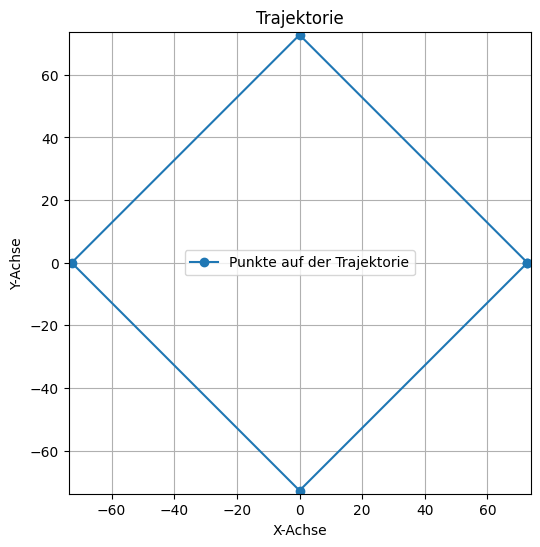

Bewege den Drucker zu Position 1 (x=72.75, y=0.0)
b'ok\n'


Drücke Enter, um zur nächsten Position zu gehen... 


Bewege den Drucker zu Position 2 (x=4.454652731898497e-15, y=72.75)
b'ok\n'


Drücke Enter, um zur nächsten Position zu gehen... 


Bewege den Drucker zu Position 3 (x=-72.75, y=8.909305463796995e-15)
b'ok\n'


Drücke Enter, um zur nächsten Position zu gehen... 


Bewege den Drucker zu Position 4 (x=-1.336395819569549e-14, y=-72.75)
b'ok\n'


Drücke Enter, um zur nächsten Position zu gehen... 


Kalibrierung abgeschlossen. Rückkehr zum Ursprung...
b'ok\n'
Kalibrierung abgeschlossen.


In [15]:
def check_position(center_pos):
    
    positions_to_check = [0, 1, 2, 3]  

    for idx in positions_to_check:
        print(f"Bewege den Drucker zu Position {idx + 1} (x={center_pos[idx][0]}, y={center_pos[idx][1]})")
        printer.move_to_absolute_x_y(center_pos[idx])

        input("Drücke Enter, um zur nächsten Position zu gehen...")

    print("Kalibrierung abgeschlossen. Rückkehr zum Ursprung...")
    printer.x_y_center()

    print("Kalibrierung abgeschlossen.")


import matplotlib.pyplot as plt
import numpy as np

def plot_trajectory(center_pos):
    center_pos = np.array(center_pos)  
    plt.figure(figsize=(6, 6))
    plt.plot(center_pos[:, 0], center_pos[:, 1], 'o-', label="Punkte auf der Trajektorie")
    
    # Achsenlimits setzen, damit der Kreis sichtbar bleibt
    plt.xlim(np.min(center_pos[:, 0])-1, np.max(center_pos[:, 0])+1)
    plt.ylim(np.min(center_pos[:, 1])-1, np.max(center_pos[:, 1])+1)
    
    # Achsen beschriften
    plt.xlabel("X-Achse")
    plt.ylabel("Y-Achse")
    plt.title("Trajektorie")
    plt.gca().set_aspect('equal', adjustable='box')  
    
    plt.grid(True)
    plt.legend()
    plt.show()


center_pos = createTrajectory("Kreis", r_path=0.75*97, r_path_variations=None, bound=0, num_points=5)
plot_trajectory(center_pos)
check_position(center_pos)

In [ ]:
check_position(center_pos)

In [8]:
center_pos = createTrajectory("Kreis", r_path=0.75*97, r_path_variations=None, bound=0, num_points=20)
center_pos = center_pos + [180, 180]
print(center_pos)

[[252.75       180.        ]
 [248.80820433 203.62188638]
 [237.40997206 224.68397485]
 [219.7904785  240.90386129]
 [197.85906919 250.52386935]
 [173.99235262 252.50152187]
 [150.77665786 246.62250951]
 [130.72776566 233.5239145 ]
 [116.0182846  214.62517284]
 [108.24221518 191.97425644]
 [108.24221518 168.02574356]
 [116.0182846  145.37482716]
 [130.72776566 126.4760855 ]
 [150.77665786 113.37749049]
 [173.99235262 107.49847813]
 [197.85906919 109.47613065]
 [219.7904785  119.09613871]
 [237.40997206 135.31602515]
 [248.80820433 156.37811362]
 [252.75       180.        ]]


In [ ]:
double_pi = 2 * np.pi

t = np.linspace(0, 2 * np.pi, 4+1)  #0, 0.5pi, pi, 1.5pi, 2pi
pos = []     
x = r_path * np.cos(t)
y = r_path * np.sin(t)
#print(x)
#print(y)

#pos = np.concatenate((x[:, np.newaxis], y[:, np.newaxis]), axis=1)
pos = np.column_stack((x, y))

print(pos)

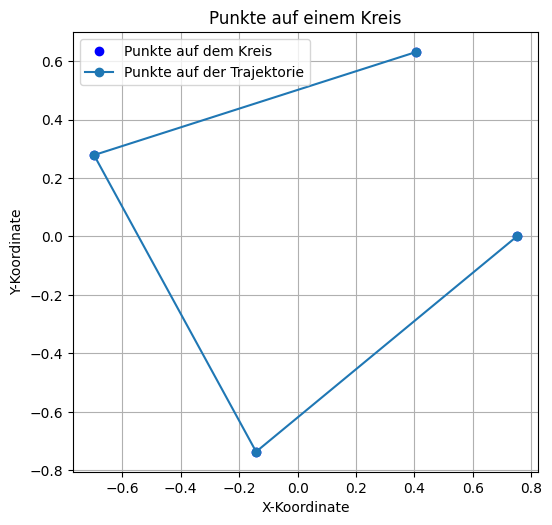

[[ 4.05226729e-01  6.31103239e-01]
 [-6.96350692e-01  2.78560073e-01]
 [-1.41839665e-01 -7.36465552e-01]
 [ 7.50000000e-01 -1.83697020e-16]]


In [146]:
plt.figure(figsize=(6,6))
plt.plot(x, y, 'bo', label='Punkte auf dem Kreis')  # 'bo' = blaue Punkte
#plt.plot(np.concatenate([x, [x[0]]]), np.concatenate([y, [y[0]]]), 'r-', label='Kreisbahn')  # Verbindet die Punkte mit einer Linie
plt.plot(pos[:, 0], pos[:, 1], 'o-', label="Punkte auf der Trajektorie")
plt.xlabel('X-Koordinate')
plt.ylabel('Y-Koordinate')
plt.title('Punkte auf einem Kreis')
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')  # Stellt sicher, dass der Kreis nicht verzerrt wird
plt.grid(True)
plt.show()

# Ausgabe der berechneten Positionen
print(pos)